In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm


In [7]:
!pip install matplotlib
import matplotlib.pyplot as plt


In [8]:

import warnings
warnings.filterwarnings('ignore')

# Load dataset
dataset_path = '/Users/rohansingh/hate_speech/PINN/0012.csv'
df = pd.read_csv(dataset_path)
x = df["Points:0"].values  # X-coordinates
y = df["Points:1"].values  # Y-coordinates
u = df["U:0"].values  # X-velocity
v = df["U:1"].values  # Y-velocity
p = df["p"].values  # Pressure

X = np.column_stack([x, y]).astype(np.float32)  # Shape: (N, 2)
Y = np.column_stack([u, v, p]).astype(np.float32)  # Shape: (N, 3)

# Create TensorFlow Dataset
batch_size = 10192
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

# Define the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh', input_shape=(2,)),  # Input (x, y)
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(3)  # Output: (u, v, p)
])


Training Progress:   0%|          | 1/1000 [00:07<1:57:21,  7.05s/it]

Epoch 0, Loss: 30841.432254


Training Progress:   5%|▌         | 51/1000 [05:29<1:42:28,  6.48s/it]

Epoch 50, Loss: 25271.574556


Training Progress:  10%|█         | 101/1000 [10:56<1:37:16,  6.49s/it]

Epoch 100, Loss: 19504.107987


Training Progress:  15%|█▌        | 151/1000 [22:32<1:32:20,  6.53s/it]  

Epoch 150, Loss: 15884.905162


Training Progress:  20%|██        | 201/1000 [27:58<1:25:45,  6.44s/it]

Epoch 200, Loss: 13164.587348


Training Progress:  25%|██▌       | 251/1000 [33:18<1:19:37,  6.38s/it]

Epoch 250, Loss: 10985.239140


Training Progress:  30%|███       | 301/1000 [38:41<1:17:51,  6.68s/it]

Epoch 300, Loss: 9193.601270


Training Progress:  35%|███▌      | 351/1000 [44:15<1:16:10,  7.04s/it]

Epoch 350, Loss: 7681.273885


Training Progress:  40%|████      | 401/1000 [50:16<1:20:02,  8.02s/it]

Epoch 400, Loss: 6960.884233


Training Progress:  45%|████▌     | 451/1000 [56:06<1:01:21,  6.71s/it]

Epoch 450, Loss: 5564.527600


Training Progress:  50%|█████     | 501/1000 [1:01:41<55:05,  6.62s/it]

Epoch 500, Loss: 4724.227717


Training Progress:  55%|█████▌    | 551/1000 [1:07:16<48:25,  6.47s/it]  

Epoch 550, Loss: 4047.789511


Training Progress:  60%|██████    | 601/1000 [1:12:41<42:54,  6.45s/it]

Epoch 600, Loss: 3635.660396


Training Progress:  65%|██████▌   | 651/1000 [1:18:02<38:17,  6.58s/it]

Epoch 650, Loss: 3049.418940


Training Progress:  70%|███████   | 701/1000 [1:23:26<32:06,  6.44s/it]

Epoch 700, Loss: 2425.589878


Training Progress:  75%|███████▌  | 751/1000 [1:28:50<27:12,  6.56s/it]

Epoch 750, Loss: 1995.718279


Training Progress:  80%|████████  | 801/1000 [1:35:29<21:08,  6.38s/it]  

Epoch 800, Loss: 1868.710515


Training Progress:  85%|████████▌ | 851/1000 [1:40:49<15:50,  6.38s/it]

Epoch 850, Loss: 1774.758052


Training Progress:  90%|█████████ | 901/1000 [1:46:53<10:36,  6.42s/it]

Epoch 900, Loss: 1478.428541


Training Progress:  95%|█████████▌| 951/1000 [1:52:12<05:15,  6.44s/it]

Epoch 950, Loss: 1196.266193


Training Progress: 100%|██████████| 1000/1000 [1:57:27<00:00,  7.05s/it]


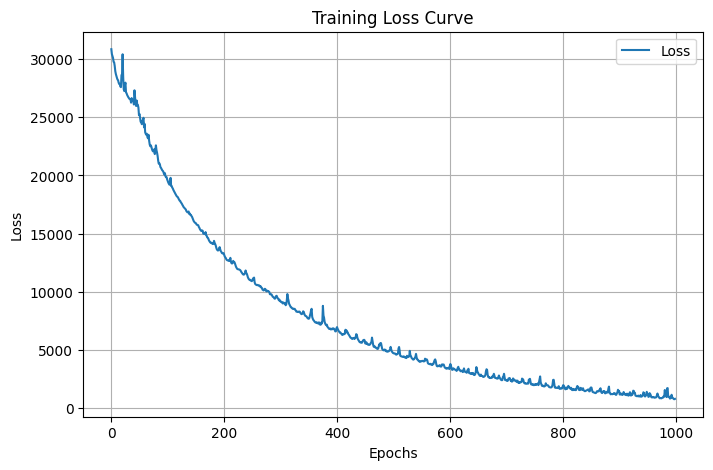

In [ ]:

# Define Loss Function with Continuity Equation
def loss_function(model, X, Y, lambda_physics=1.0):
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        Y_pred = model(X)  # Predicted (u, v, p)
        
        # Data Loss (MSE)
        data_loss = tf.reduce_mean(tf.square(Y_pred - Y))
        
        # Extract predicted velocity components
        u_pred = Y_pred[:, 0]  # u
        v_pred = Y_pred[:, 1]  # v
        
        # Compute spatial derivatives efficiently
        with tf.GradientTape() as g_tape:
            g_tape.watch(X)
            u_pred = model(X)[:, 0]  # Recompute u_pred for derivatives
        grad_u = g_tape.gradient(u_pred, X)  # [du/dx, du/dy]
        du_dx = grad_u[:, 0]  # ∂u/∂x
        
        with tf.GradientTape() as g_tape:
            g_tape.watch(X)
            v_pred = model(X)[:, 1]  # Recompute v_pred for derivatives
        grad_v = g_tape.gradient(v_pred, X)  # [dv/dx, dv/dy]
        dv_dy = grad_v[:, 1]  # ∂v/∂y
        
        # Physics Loss: Continuity Equation (∂u/∂x + ∂v/∂y = 0)
        continuity_eq = du_dx + dv_dy
        physics_loss = tf.reduce_mean(tf.square(continuity_eq))
    
    # Clean up persistent tape to avoid memory leaks
    del tape
    
    # Total Loss
    return data_loss + lambda_physics * physics_loss

# Training Setup
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
n_epochs = 1000
loss_history = []

# Training Loop
for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    epoch_loss = 0.0
    for batch_X, batch_Y in dataset:
        with tf.GradientTape() as tape:
            loss = loss_function(model, batch_X, batch_Y, lambda_physics=1.0)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss += loss.numpy()
    
    avg_loss = epoch_loss / len(dataset)
    loss_history.append(avg_loss)
    
    if epoch % 50 == 0:  # Print more frequently for monitoring
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Save the model
model.save("pinn_velocity_pressure_model.h5")

# Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

Training Progress:   0%|          | 1/1000 [00:02<43:24,  2.61s/it]

Epoch 0, Loss: 83329.389757


Training Progress:   5%|▌         | 51/1000 [00:54<16:30,  1.04s/it]

Epoch 50, Loss: 27946.129242


Training Progress:  10%|█         | 101/1000 [01:47<15:57,  1.06s/it]

Epoch 100, Loss: 25365.858487


Training Progress:  15%|█▌        | 151/1000 [02:41<15:09,  1.07s/it]

Epoch 150, Loss: 22916.707505


Training Progress:  20%|██        | 201/1000 [03:34<14:16,  1.07s/it]

Epoch 200, Loss: 20868.555773


Training Progress:  25%|██▌       | 251/1000 [04:32<15:52,  1.27s/it]

Epoch 250, Loss: 19146.690972


Training Progress:  30%|███       | 301/1000 [05:31<13:13,  1.14s/it]

Epoch 300, Loss: 17677.369535


Training Progress:  35%|███▌      | 351/1000 [06:28<12:08,  1.12s/it]

Epoch 350, Loss: 16394.483921


Training Progress:  40%|████      | 401/1000 [07:25<11:24,  1.14s/it]

Epoch 400, Loss: 15267.971591


Training Progress:  45%|████▌     | 451/1000 [08:22<10:38,  1.16s/it]

Epoch 450, Loss: 14266.912524


Training Progress:  50%|█████     | 501/1000 [09:21<09:46,  1.17s/it]

Epoch 500, Loss: 13373.925051


Training Progress:  55%|█████▌    | 551/1000 [10:19<08:40,  1.16s/it]

Epoch 550, Loss: 12569.265724


Training Progress:  60%|██████    | 601/1000 [11:17<07:40,  1.15s/it]

Epoch 600, Loss: 11843.109059


Training Progress:  65%|██████▌   | 651/1000 [12:16<06:42,  1.15s/it]

Epoch 650, Loss: 11182.358655


Training Progress:  70%|███████   | 701/1000 [13:14<05:49,  1.17s/it]

Epoch 700, Loss: 10582.005593


Training Progress:  75%|███████▌  | 751/1000 [14:12<04:46,  1.15s/it]

Epoch 750, Loss: 10030.431049


Training Progress:  80%|████████  | 801/1000 [15:11<03:54,  1.18s/it]

Epoch 800, Loss: 9525.578470


Training Progress:  85%|████████▌ | 851/1000 [16:12<03:08,  1.26s/it]

Epoch 850, Loss: 9061.759381


Training Progress:  90%|█████████ | 901/1000 [17:11<01:48,  1.09s/it]

Epoch 900, Loss: 8634.863824


Training Progress:  95%|█████████▌| 951/1000 [18:06<00:53,  1.10s/it]

Epoch 950, Loss: 8241.065775


Training Progress: 100%|██████████| 1000/1000 [19:02<00:00,  1.14s/it]


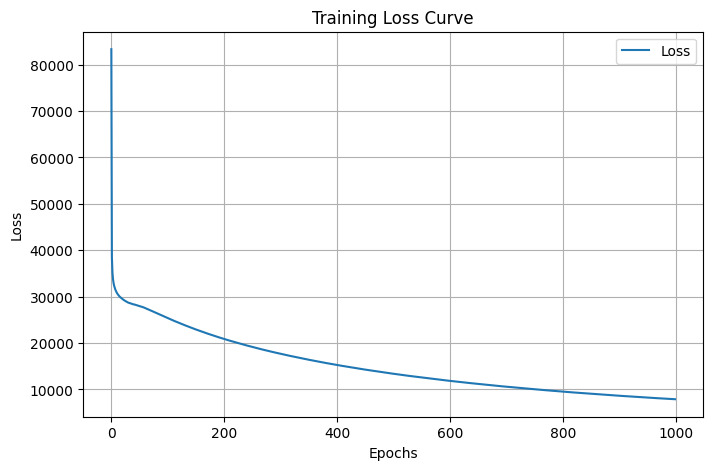

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

dataset_path = '/Users/rohansingh/hate_speech/PINN/0012.csv'
df = pd.read_csv(dataset_path)
x = df["Points:0"].values  # X-coordinates
y = df["Points:1"].values  # Y-coordinates
u = df["U:0"].values  # X-velocity
v = df["U:1"].values  # Y-velocity
p = df["p"].values  # Pressure

X = np.column_stack([x, y]).astype(np.float32)  
Y = np.column_stack([u, v, p]).astype(np.float32)  

batch_size = 10192
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh', input_shape=(2,)),  # Input (x, y)
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(3)  # Output: (u, v, p)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error')

n_epochs = 1000
history = []  

for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    epoch_loss = 0.0
    for batch_X, batch_Y in dataset:
        loss = model.train_on_batch(batch_X, batch_Y)  
        epoch_loss += loss
    
    avg_loss = epoch_loss / len(dataset)
    history.append(avg_loss)
    
    if epoch % 50 == 0:  
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

model.save("velocity_pressure_model.h5")

plt.figure(figsize=(8, 5))
plt.plot(history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
df_new = pd.read_csv('/Users/rohansingh/hate_speech/PINN/0015.csv')

In [17]:
# "Points:0","Points:1"
model= tf.keras.models.load_model("pinn_velocity_pressure_model.h5")

Fine-Tuning Progress:   1%|          | 1/100 [00:09<15:04,  9.14s/it]

Epoch 0, Loss: 747.734253


Fine-Tuning Progress:  51%|█████     | 51/100 [44:39<09:58, 12.20s/it]    

Epoch 50, Loss: 94.087471


Fine-Tuning Progress: 100%|██████████| 100/100 [55:15<00:00, 33.16s/it]


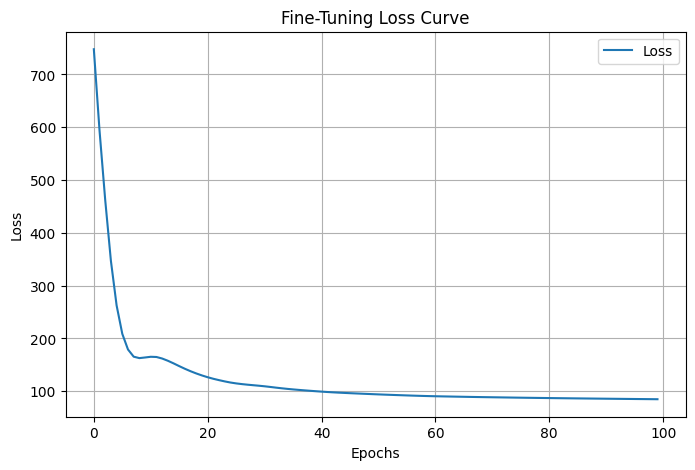

31219/31219 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step
Predictions: [[   27.189148      4.8483996 -1019.48035  ]
 [   27.189095      4.8484497 -1018.92377  ]
 [   27.189037      4.8485017 -1018.3474   ]
 [   27.170792      4.8507257  -975.3535   ]
 [   27.170761      4.850726   -975.14905  ]]


In [22]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load data
df_new = pd.read_csv('/Users/rohansingh/hate_speech/PINN/0015.csv')

# Define the custom loss function
def loss_function(model, X, Y, lambda_physics=1.0):
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        Y_pred = model(X)  # Predicted (u, v, p)
        
        data_loss = tf.reduce_mean(tf.square(Y_pred - Y))
        
        u_pred = Y_pred[:, 0]
        v_pred = Y_pred[:, 1]
        
        with tf.GradientTape() as g_tape:
            g_tape.watch(X)
            u_pred = model(X)[:, 0]
        grad_u = g_tape.gradient(u_pred, X)
        du_dx = grad_u[:, 0]
        
        with tf.GradientTape() as g_tape:
            g_tape.watch(X)
            v_pred = model(X)[:, 1]
        grad_v = g_tape.gradient(v_pred, X)
        dv_dy = grad_v[:, 1]
        
        continuity_eq = du_dx + dv_dy
        physics_loss = tf.reduce_mean(tf.square(continuity_eq))
    
    del tape
    return data_loss + lambda_physics * physics_loss

# Load the model
model = tf.keras.models.load_model('pinn_velocity_pressure_model.h5', custom_objects={'loss_function': loss_function})

# Prepare input data
x_new = df_new['Points:0'].values
y_new = df_new['Points:1'].values
X_new = np.column_stack([x_new, y_new]).astype(np.float32)

# Assume ground truth (replace with actual data)
Y_new = df_new[['U:0', 'U:1', 'p']].values.astype(np.float32)  # Adjust column names

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Custom training step
@tf.function
def train_step(model, X, Y):
    with tf.GradientTape() as tape:
        loss = loss_function(model, X, Y, lambda_physics=1.0)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# Fine-tune (optional)
n_epochs = 100
loss_history = []
for epoch in tqdm(range(n_epochs), desc="Fine-Tuning Progress"):
    loss = train_step(model, X_new, Y_new)
    avg_loss = loss.numpy()
    loss_history.append(avg_loss)
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-Tuning Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Predict
predictions = model.predict(X_new)
print("Predictions:", predictions[:5])

In [25]:
model.save('my_model.keras')

In [26]:
model1 = tf.keras.models.load_model("my_model.keras")

In [ ]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,019 (179.76 KB)

 Trainable params: 46,019 (179.76 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
x = -1.5179e-07
y = 0.00014986
input_data = np.array([[x, y]])  # Shape: (1, 2)
y_pred=model1.predict(input_data)
print("Predicted velocity and pressure:", y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
Predicted velocity and pressure: [[   27.18915       4.8483996 -1019.4803   ]]


In [30]:
error = np.abs(y_pred - Y_new[0])
print("Error:", error)

Error: [[27.18915    4.8483996 10.280273 ]]
